In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from pyswarms.single.global_best import GlobalBestPSO


Fitted parameters:
  h = 4.9993
  k = 8.0178
  a = 0.2731
  b = 0.9696
  θ = -0.0091 rad


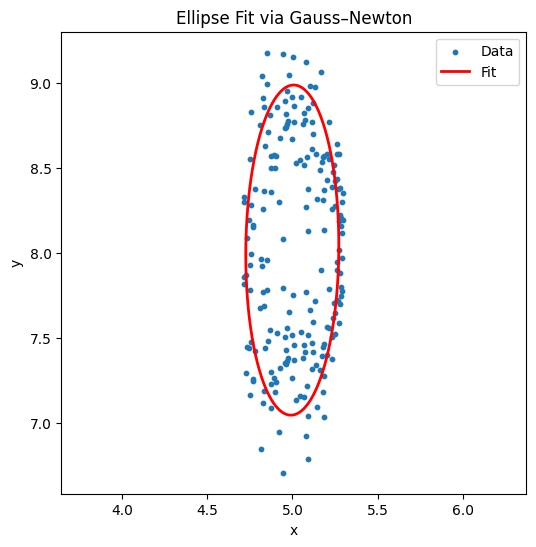

In [19]:
# load data from file
data = np.loadtxt('data.txt')
x = data[:, 0]
y = data[:, 1]
# Define the residual function
def ellipse_residuals(params, x, y):
    h = params[0]
    k = params[1]
    a = params[2]
    b = params[3]
    theta = params[4]
    c, s = np.cos(theta), np.sin(theta)
    u =  (x - h)*c + (y - k)*s
    v = -(x - h)*s + (y - k)*c
    return (u/a)**2 + (v/b)**2 - 1
# Define the Jacobian
def ellipse_jacobian(params, x, y):
    h = params[0]
    k = params[1]
    a = params[2]
    b = params[3]
    theta = params[4]
    c, s = np.cos(theta), np.sin(theta)
    dx = x - h
    dy = y - k
    u =  dx*c + dy*s
    v = -dx*s + dy*c

    # partials of (u/a)^2 + (v/b)^2 - 1
    du_dh = -c
    du_dk = -s
    dv_dh =  s
    dv_dk = -c
    du_dt = -dx*s + dy*c
    dv_dt = -dx*c - dy*s

    dr_dh = 2*(u/a**2)*du_dh + 2*(v/b**2)*dv_dh
    dr_dk = 2*(u/a**2)*du_dk + 2*(v/b**2)*dv_dk
    dr_da = -2 * u**2 / a**3
    dr_db = -2 * v**2 / b**3
    dr_dt = 2*(u/a**2)*du_dt + 2*(v/b**2)*dv_dt

    # stack into N×5 Jacobian
    jacobian = np.vstack([dr_dh, dr_dk, dr_da, dr_db, dr_dt])
    return jacobian.T

# Initial guess
h0, k0 = x.mean(), y.mean()
a0 = (x.max() - x.min())/2
b0 = (y.max() - y.min())/2
theta0 = 0
p0 = [h0, k0, a0, b0, theta0]

# Fit the ellipse using least squares
res = least_squares(
    ellipse_residuals, p0, jac=ellipse_jacobian,
    args=(x, y), method='lm',
    xtol=1e-12, ftol=1e-12
)

h, k, a, b, theta = res.x
# Results
print("Fitted parameters:")
print(f"  h = {h:.4f}")
print(f"  k = {k:.4f}")
print(f"  a = {a:.4f}")
print(f"  b = {b:.4f}")
print(f"  θ = {theta:.4f} rad")

# Plot data and fitted ellipse
t = np.linspace(0, 2*np.pi, 400)
X_fit = h + a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta)
Y_fit = k + a*np.cos(t)*np.sin(theta) + b*np.sin(t)*np.cos(theta)

plt.figure(figsize=(6,6))
plt.scatter(x, y, s=10, label='Data')
plt.plot(X_fit, Y_fit, 'r-', lw=2, label='Fit')
plt.axis('equal')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Ellipse Fit via Gauss–Newton')
plt.legend()
plt.show()

In [20]:
# Initial guess for parameters
h0 = np.mean(x)
k0 = np.mean(y)
a0 = (np.max(x) - np.min(x)) / 2
b0 = (np.max(y) - np.min(y)) / 2
theta0 = 0.0

p0 = np.array([h0, k0, a0, b0, theta0])

# Define Gauss-Newton method
def gauss_newton(residual_fn, jacobian_fn, p_start, x, y, tol=1e-12, max_iter=50):
    p = p_start.copy()
    for i in range(max_iter):
        r = residual_fn(p, x, y)
        J = jacobian_fn(p, x, y)
        
        JT = J.T
        JTJ = np.dot(JT, J)
        JTr = np.dot(JT, r)

        # Solve linear system JTJ * delta = -JTr
        delta = np.linalg.lstsq(JTJ, -JTr, rcond=None)[0]
        p = p + delta

        if np.linalg.norm(delta) < tol:
            break

    final_res = residual_fn(p, x, y)
    result = {}
    result["params"] = p
    result["n_iterations"] = i + 1
    result["sum_of_squares"] = np.sum(final_res ** 2)
    result["jacobian_condition"] = np.linalg.cond(jacobian_fn(p, x, y))
    return result

# Run Gauss-Newton
gn_results = gauss_newton(ellipse_residuals, ellipse_jacobian, p0, x, y)

# Run Levenberg-Marquardt (built-in)
lm = least_squares(
    ellipse_residuals,
    p0,
    jac=ellipse_jacobian,
    args=(x, y),
    method='lm',
    xtol=1e-12,
    ftol=1e-12,
    gtol=1e-12,
    max_nfev=2000
)

# Collect LM results
lm_results = {}
lm_results["params"] = lm.x
lm_results["n_jacobian_evals"] = lm.njev
lm_results["sum_of_squares"] = 2 * lm.cost
lm_results["jacobian_condition"] = np.linalg.cond(ellipse_jacobian(lm.x, x, y))

# Print results
print("---- Gauss–Newton ----")
print("Iterations         :", gn_results["n_iterations"])
print("Sum-of-squares loss:", "%.6e" % gn_results["sum_of_squares"])
print("Condition number J :", "%.6e" % gn_results["jacobian_condition"])
print("Fitted parameters  :", np.round(gn_results["params"], 6))

print("")
print("---- Levenberg–Marquardt ----")
print("Jacobian evals     :", lm_results["n_jacobian_evals"])
print("Sum-of-squares loss:", "%.6e" % lm_results["sum_of_squares"])
print("Condition number J :", "%.6e" % lm_results["jacobian_condition"])
print("Fitted parameters  :", np.round(lm_results["params"], 6))

---- Gauss–Newton ----
Iterations         : 17
Sum-of-squares loss: 3.424281e+01
Condition number J : 4.977251e+00
Fitted parameters  : [ 4.999315  8.017751  0.273092  0.969594 -0.009107]

---- Levenberg–Marquardt ----
Jacobian evals     : 9
Sum-of-squares loss: 3.424281e+01
Condition number J : 4.977251e+00
Fitted parameters  : [ 4.999315  8.017751  0.273092  0.969594 -0.009107]


Initial guess       : Reasonable (BBox-centre)
Convergence status  : `ftol` termination condition is satisfied.
Jacobian evaluations: 9
Final loss          : 3.424281e+01
Condition number J  : 4.977e+00
Fitted parameters   : [ 4.999315  8.017751  0.273092  0.969594 -0.009107]
----------------------------------------------------------------------
Initial guess       : Too large + rotated
Convergence status  : The maximum number of function evaluations is exceeded.
Jacobian evaluations: 396
Final loss          : 7.570258e-15
Condition number J  : 1.985e+17
Fitted parameters   : [ 5.72044988e+07 -7.33051664e+05  6.34935445e+05  5.72091905e+07
  1.55798200e+00]
----------------------------------------------------------------------
Initial guess       : Underscaled
Convergence status  : The maximum number of function evaluations is exceeded.
Jacobian evaluations: 392
Final loss          : 3.424308e-14
Condition number J  : 4.976e+15
Fitted parameters   : [-2.65000856e+07  6.60099355e+05  2.

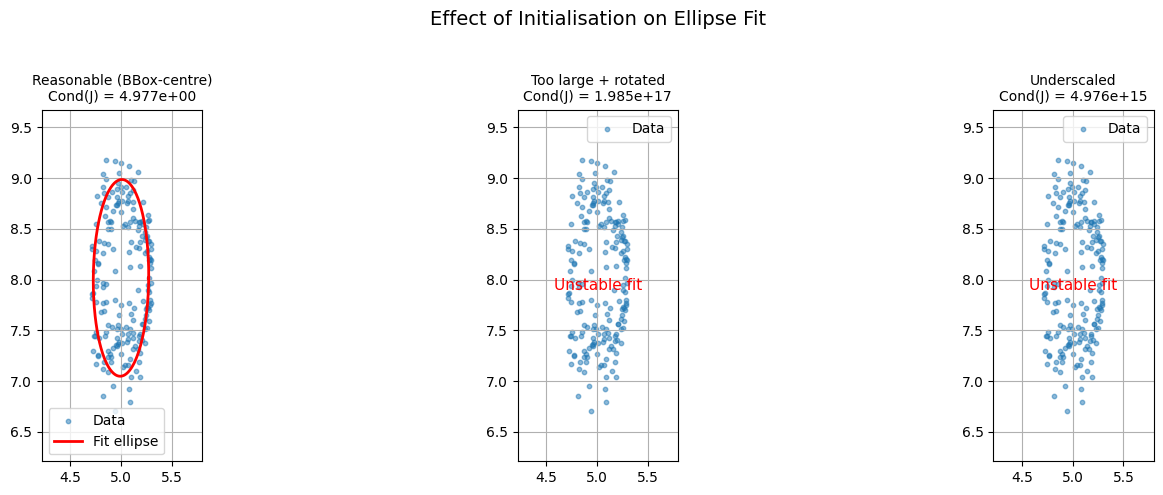

In [21]:
# Function to compute condition number of Jacobian
def condition_number(jac):
    s = np.linalg.svd(jac, compute_uv=False)
    if s[-1] > 0:
        return s[0] / s[-1]
    else:
        return np.inf

# Define different initial guesses
init_guesses = dict()

init_guesses["Reasonable (BBox-centre)"] = [
    np.mean(x),
    np.mean(y),
    0.5 * (np.max(x) - np.min(x)),
    0.5 * (np.max(y) - np.min(y)),
    0.0
]

init_guesses["Too large + rotated"] = [
    np.mean(x) + 1.5,
    np.mean(y) - 1.0,
    3.0, 3.0,
    np.pi / 4
]

init_guesses["Underscaled"] = [
    np.mean(x),
    np.mean(y),
    0.05, 0.05,
    0.0
]

results = []

# Fit ellipses for each initial guess
for key in init_guesses:
    p0 = init_guesses[key]
    result = least_squares(
        ellipse_residuals,
        p0,
        jac=ellipse_jacobian,
        args=(x, y),
        method='lm',
        xtol=1e-12,
        ftol=1e-12,
        gtol=1e-12
    )

    res_dict = {}
    res_dict["Initial"] = key
    res_dict["Status"] = result.message.split('\n')[0]
    res_dict["Jac evals"] = result.njev
    res_dict["Final loss"] = 2 * result.cost
    res_dict["Cond(J)"] = "%.3e" % condition_number(result.jac)
    res_dict["Params"] = np.round(result.x, 6)

    results.append(res_dict)

# Print the results
for r in results:
    print("Initial guess       :", r["Initial"])
    print("Convergence status  :", r["Status"])
    print("Jacobian evaluations:", r["Jac evals"])
    print("Final loss          :", "%.6e" % r["Final loss"])
    print("Condition number J  :", r["Cond(J)"])
    print("Fitted parameters   :", r["Params"])
    print("-" * 70)

# Visualize the fitted ellipses
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

x_min = np.min(x) - 0.5
x_max = np.max(x) + 0.5
y_min = np.min(y) - 0.5
y_max = np.max(y) + 0.5

t = np.linspace(0, 2 * np.pi, 400)

for i in range(3):
    r = results[i]
    h, k, a, b, theta = r["Params"]
    cond_str = r["Cond(J)"]
    cond_val = float(cond_str.replace("e+", "e").replace("e", "e+"))

    ax = axs[i]
    ax.scatter(x, y, s=10, alpha=0.5, label="Data")

    if cond_val < 1e6:
        cos_t = np.cos(theta)
        sin_t = np.sin(theta)
        x_fit = h + a * np.cos(t) * cos_t - b * np.sin(t) * sin_t
        y_fit = k + a * np.cos(t) * sin_t + b * np.sin(t) * cos_t
        ax.plot(x_fit, y_fit, 'r-', linewidth=2, label="Fit ellipse")
    else:
        ax.text(0.5, 0.5, "Unstable fit", color='red', fontsize=11,
                ha='center', va='center', transform=ax.transAxes)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')
    ax.set_title(r["Initial"] + "\nCond(J) = " + cond_str, fontsize=10)
    ax.grid(True)
    ax.legend()

plt.suptitle("Effect of Initialisation on Ellipse Fit", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

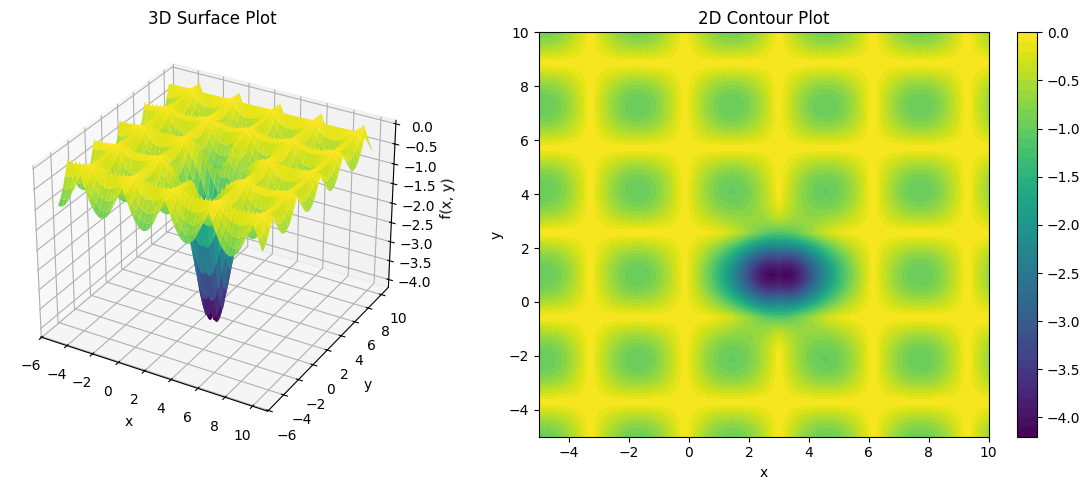

In [22]:
# My student ID:150220313
a = 3
b = 1

# Define the dolphin function
def dolphin(x, y):
    part1 = np.sin(x - a)
    part2 = np.cos(y - b)
    term1 = np.abs(part1 * part2)
    
    term2 = (x - 3)**2 + (y - 1)**2
    exp_term = np.exp(-0.5 * term2)
    
    return -term1 - 4 * exp_term

# Create the grid for x and y
x_vals = np.linspace(-5, 10, 400)
y_vals = np.linspace(-5, 10, 400)
X, Y = np.meshgrid(x_vals, y_vals)

# Evaluate the function on the grid
Z = dolphin(X, Y)

# Start figure
fig = plt.figure(figsize=(12, 5))

# First subplot: 3D surface plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('f(x, y)')
ax1.set_title('3D Surface Plot')

# Second subplot: 2D contour plot
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour, ax=ax2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('2D Contour Plot')

# Show layout and plot
plt.tight_layout()
plt.show()

In [23]:
# Define the PSO-compatible function
def dolphin_for_pso(X):
    x_vals = X[:, 0]
    y_vals = X[:, 1]
    return dolphin(x_vals, y_vals)

# Define search space bounds
lower_bounds = np.array([-5, -5])
upper_bounds = np.array([10, 10])
bounds = (lower_bounds, upper_bounds)

# Number of trials
num_trials = 25
fitness_vals = []

# Run optimization multiple times
for trial in range(num_trials):
    np.random.seed(trial)

    # Set up the optimizer
    optimizer = GlobalBestPSO(
        n_particles=30,
        dimensions=2,
        options={'c1': 1.5, 'c2': 1.5, 'w': 0.5},
        bounds=bounds
    )

    # Run optimization
    result = optimizer.optimize(dolphin_for_pso, iters=100)
    cost = result[0]
    fitness_vals.append(cost)

# Convert list to array
fitness_vals = np.array(fitness_vals)

# Success criteria
best_known = -4.0
threshold = best_known + 0.001
count_success = 0

for val in fitness_vals:
    if val <= threshold:
        count_success += 1

# Print results
mean_val = np.mean(fitness_vals)
std_val = np.std(fitness_vals)
success_rate = 100.0 * count_success / num_trials

print("Mean fitness value:", mean_val)
print("Standard deviation:", std_val)
print("Success rate:", success_rate, "%")

2025-05-03 21:53:54,097 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-4.12
2025-05-03 21:53:54,148 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.124336910415786, best pos: [2.75008264 1.        ]
2025-05-03 21:53:54,153 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-4.12
2025-05-03 21:53:54,202 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.124336910415786, best pos: [2.75008265 1.00000001]
2025-05-03 21:53:54,205 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-4.12
2025-05-03 21:53:54,249 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.1243369104157

Mean fitness value: -4.124336910415787
Standard deviation: 8.881784197001252e-16
Success rate: 100.0 %


In [24]:
fitness_vals = list()

# Domain limits
domain_min = -10
domain_max = 10

# Number of trials
trial_range = 25

# For reproducibility
np.random.seed(42)

# Loop over 25 trials
for i in range(trial_range):
    # Create a random rectangle with width = 4
    x_min = np.random.uniform(domain_min, domain_max - 4)
    y_min = np.random.uniform(domain_min, domain_max - 4)
    x_max = x_min + 4
    y_max = y_min + 4

    # Set up bounds for this trial
    lower_bounds = np.array([x_min, y_min])
    upper_bounds = np.array([x_max, y_max])
    bounds = (lower_bounds, upper_bounds)

    # Create and run the optimizer
    optimizer = GlobalBestPSO(
        n_particles=30,
        dimensions=2,
        options={'c1': 1.5, 'c2': 1.5, 'w': 0.5},
        bounds=bounds
    )

    result = optimizer.optimize(dolphin_for_pso, iters=100)
    cost = result[0]
    fitness_vals.append(cost)

# Convert list to array
fitness_vals = np.array(fitness_vals)

# Evaluate success rate
f_star = -4.0
threshold = f_star + 0.001

success_count = 0
for val in fitness_vals:
    if val <= threshold:
        success_count += 1

# Report results
mean_val = np.mean(fitness_vals)
std_val = np.std(fitness_vals)
success_rate = 100.0 * success_count / trial_range

print("Mean fitness (restricted domain):", mean_val)
print("Std. dev:", std_val)
print("Success rate:", success_rate, "%")

2025-05-03 21:53:55,833 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1  
2025-05-03 21:53:55,859 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.0000000000001612, best pos: [-1.71238898  7.2831853 ]
2025-05-03 21:53:55,861 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1  
2025-05-03 21:53:55,888 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.000000003116314, best pos: [4.57079632 7.28318529]
2025-05-03 21:53:55,891 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-1  
2025-05-03 21:53:55,920 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.0000000031163

Mean fitness (restricted domain): -1.6289856447130533
Std. dev: 1.2167028037197385
Success rate: 16.0 %


In [25]:
def dolphin_noisy(x, y, sigma=0.0412):
    clean = dolphin(x, y)
    noise = np.random.normal(0, sigma, size=clean.shape)
    return clean + noise

def dolphin_for_pso_noisy(X):
    return dolphin_noisy(X[:, 0], X[:, 1])

In [26]:
# Empty list to store results
fitness_vals = []

# Number of trials
num_trials = 25

# Search space boundaries
lower_bound = np.array([-5, -5])
upper_bound = np.array([10, 10])
bounds = (lower_bound, upper_bound)

# Run optimizer multiple times with different seeds
for trial in range(num_trials):
    np.random.seed(trial)

    optimizer = GlobalBestPSO(
        n_particles=30,
        dimensions=2,
        options={'c1': 1.5, 'c2': 1.5, 'w': 0.5},
        bounds=bounds
    )

    result = optimizer.optimize(dolphin_for_pso_noisy, iters=100)
    cost = result[0]
    fitness_vals.append(cost)

# Convert to array
fitness_vals = np.array(fitness_vals)

# Define threshold for success
f_star = -4.0
threshold = f_star + 0.001

# Count how many runs succeeded
success_count = 0
for val in fitness_vals:
    if val <= threshold:
        success_count += 1

# Calculate and print statistics
mean_fitness = np.mean(fitness_vals)
std_fitness = np.std(fitness_vals)
success_rate = (success_count / num_trials) * 100

print("Mean fitness (noisy):", mean_fitness)
print("Std. dev:", std_fitness)
print("Success rate:", success_rate, "%")

2025-05-03 21:53:57,953 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-4.25
2025-05-03 21:53:57,979 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.247961697083083, best pos: [3.19961245 0.98953404]
2025-05-03 21:53:57,981 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-4.26
2025-05-03 21:53:58,006 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.257255566243304, best pos: [3.28810036 1.00294284]
2025-05-03 21:53:58,009 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-4.25
2025-05-03 21:53:58,033 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.2492967804787

Mean fitness (noisy): -4.262868672942395
Std. dev: 0.017466447468816603
Success rate: 100.0 %


In [27]:
budgets = {
    750: 25,
    1000: 34,
    1500: 50
}

n_particles = 30
bounds = (np.array([-5, -5]), np.array([10, 10]))

for budget, iters in budgets.items():
    print(f"\n--- Budget: {budget} evaluations ({iters} iterations) ---")
    
    fitness_vals = []
    for seed in range(25):
        np.random.seed(seed)
        optimizer = GlobalBestPSO(
            n_particles=n_particles,
            dimensions=2,
            options={'c1': 1.5, 'c2': 1.5, 'w': 0.5},
            bounds=bounds
        )
        cost, _ = optimizer.optimize(dolphin_for_pso, iters=iters, verbose=False)
        fitness_vals.append(cost)

    fitness_vals = np.array(fitness_vals)
    f_star = -4.0
    threshold = f_star + 1e-3
    success_rate = np.sum(fitness_vals <= threshold) / 25 * 100

    print("Mean fitness:", np.mean(fitness_vals))
    print("Std. dev.:", np.std(fitness_vals))
    print("Success rate:", success_rate, "%")


--- Budget: 750 evaluations (25 iterations) ---
Mean fitness: -4.124331463018149
Std. dev.: 1.2246421932676233e-05
Success rate: 100.0 %

--- Budget: 1000 evaluations (34 iterations) ---
Mean fitness: -4.1243368766482185
Std. dev.: 8.15265072153345e-08
Success rate: 100.0 %

--- Budget: 1500 evaluations (50 iterations) ---
Mean fitness: -4.124336910410974
Std. dev.: 6.726539903236285e-12
Success rate: 100.0 %


Skipping CG path from far
Skipping CG path from difficult
Skipping Newton path from difficult


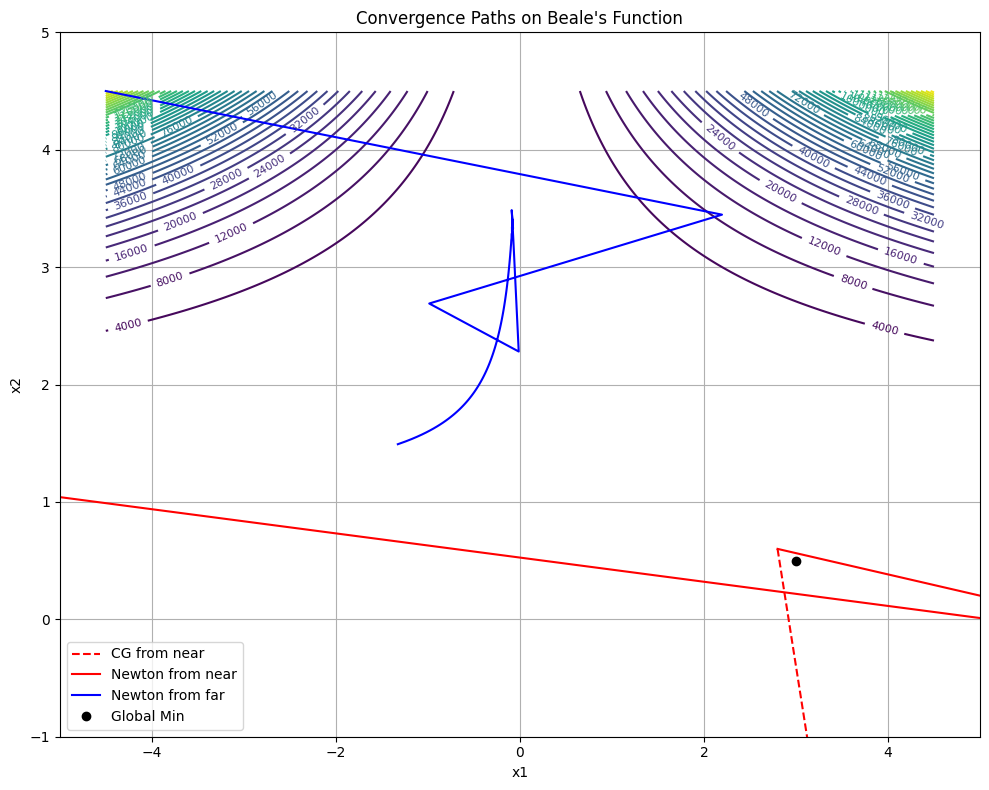

In [29]:
# --- Beale Function ---
def beale(x):
    x1 = x[0]
    x2 = x[1]
    term1 = (1.5 - x1 + x1 * x2) ** 2
    term2 = (2.25 - x1 + x1 * x2**2) ** 2
    term3 = (2.625 - x1 + x1 * x2**3) ** 2
    return term1 + term2 + term3

# --- Gradient ---
def grad_beale(x):
    x1 = x[0]
    x2 = x[1]
    df_dx1 = 2 * (1.5 - x1 + x1 * x2) * (-1 + x2) + \
             2 * (2.25 - x1 + x1 * x2**2) * (-1 + x2**2) + \
             2 * (2.625 - x1 + x1 * x2**3) * (-1 + x2**3)
    df_dx2 = 2 * (1.5 - x1 + x1 * x2) * x1 + \
             4 * (2.25 - x1 + x1 * x2**2) * x1 * x2 + \
             6 * (2.625 - x1 + x1 * x2**3) * x1 * x2**2
    return np.array([df_dx1, df_dx2])

# --- Hessian ---
def hessian_beale(x):
    x1 = x[0]
    x2 = x[1]
    H = np.zeros((2, 2))

    H[0, 0] = 2 * (1 - x2)**2 + 2 * (1 - x2**2)**2 + 2 * (1 - x2**3)**2
    H[1, 1] = 2 * x1**2 + 4 * x1**2 * x2**2 + \
              36 * (2.625 - x1 + x1 * x2**3) * x1 * x2 + \
              18 * x1**2 * x2**4
    H[0, 1] = -2 * (1.5 - x1 + x1 * x2) + \
              4 * (2.25 - x1 + x1 * x2**2) * x2 - \
              6 * (2.625 - x1 + x1 * x2**3) * x2**2 + \
              2 * x1 * (1 + 2 * x2**2 + 3 * x2**4)
    H[1, 0] = H[0, 1]
    return H

# --- Conjugate Gradient ---
def conjugate_gradient(f, grad, x0, tol=1e-6, max_iter=1000):
    x = x0.copy()
    path = [x.copy()]
    r = -grad(x)
    p = r.copy()
    
    for i in range(max_iter):
        Ap = grad(x + 1e-5 * p) - grad(x)
        alpha = np.dot(r, r) / (np.dot(p, Ap) + 1e-8)
        if alpha > 1.0:
            alpha = 1.0
        x = x + alpha * p
        path.append(x.copy())
        r_new = r + alpha * Ap
        beta = np.dot(r_new, r_new) / np.dot(r, r)
        p = -r_new + beta * p
        r = r_new
        if np.linalg.norm(r) < tol:
            break
    return x, np.array(path)

# --- Newton's Method ---
def newtons_method(f, grad, hess, x0, tol=1e-6, max_iter=100):
    x = x0.copy()
    path = [x.copy()]
    for i in range(max_iter):
        g = grad(x)
        H = hess(x)
        try:
            dx = np.linalg.solve(H, g)
        except:
            break
        x = x - dx
        path.append(x.copy())
        if np.linalg.norm(dx) < tol:
            break
    return x, np.array(path)

# --- Initial points ---
x_near = np.array([2.8, 0.6])
x_far = np.array([-4.5, 4.5])
x_difficult = np.array([0.5, 3.0])

# --- Plotting ---
x_vals = np.linspace(-4.5, 4.5, 400)
y_vals = np.linspace(-1, 4.5, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = beale([X, Y])

plt.figure(figsize=(10, 8))
contours = plt.contour(X, Y, Z, levels=50, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)

max_bound = 50
colors = ['r', 'b', 'g']
labels = ['near', 'far', 'difficult']
starts = [x_near, x_far, x_difficult]

for i in range(3):
    point = starts[i]
    label = labels[i]
    color = colors[i]

    # CG
    result_cg, path_cg = conjugate_gradient(beale, grad_beale, point)
    if np.any(np.abs(path_cg) > max_bound):
        print("Skipping CG path from", label)
    else:
        plt.plot(path_cg[:, 0], path_cg[:, 1], '--', label='CG from ' + label, color=color)

    # Newton
    result_nt, path_nt = newtons_method(beale, grad_beale, hessian_beale, point)
    if np.any(np.abs(path_nt) > max_bound):
        print("Skipping Newton path from", label)
    else:
        plt.plot(path_nt[:, 0], path_nt[:, 1], '-', label='Newton from ' + label, color=color)

# Final plot settings
plt.plot(3, 0.5, 'ko', label='Global Min')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Convergence Paths on Beale's Function")
plt.legend()
plt.grid(True)
plt.xlim(-5, 5)
plt.ylim(-1, 5)
plt.tight_layout()
plt.show()

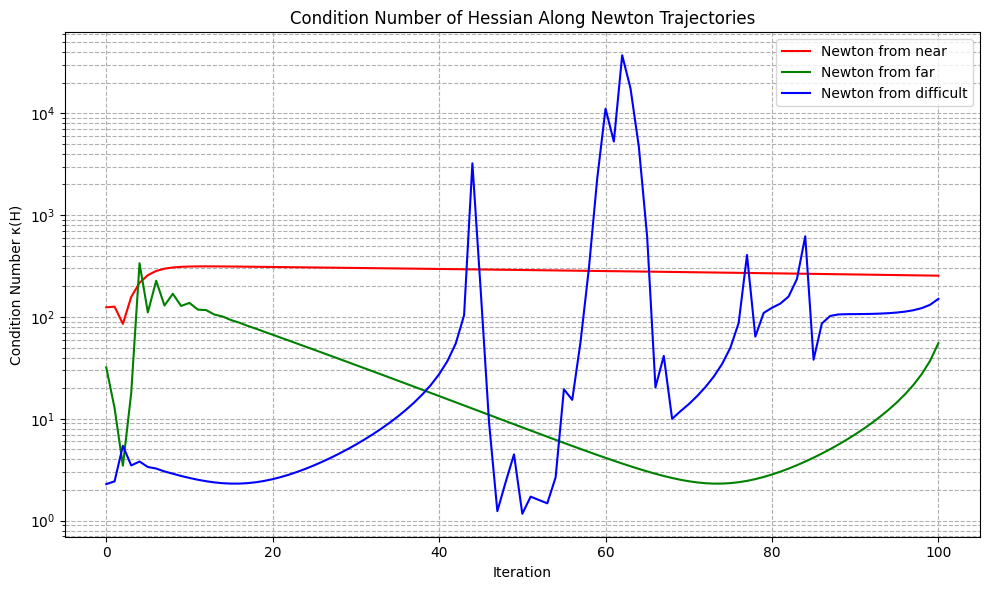

In [30]:
# Newton's Method: only record trajectory
def newton_trajectory(x0, max_iter=100):
    x = x0.copy()
    path = []
    path.append(x.copy())
    for i in range(max_iter):
        g = grad_beale(x)
        H = hessian_beale(x)
        try:
            dx = np.linalg.solve(H, g)
        except:
            break
        x = x - dx
        path.append(x.copy())
        if np.linalg.norm(dx) < 1e-6:
            break
    return np.array(path)

# Compute condition numbers along path
def compute_condition_numbers(path):
    cond_list = []
    for i in range(len(path)):
        x = path[i]
        H = hessian_beale(x)
        eigs = np.linalg.eigvals(H)
        smallest = np.min(np.abs(eigs))
        largest = np.max(np.abs(eigs))
        if smallest < 1e-8:
            cond_list.append(np.inf)
        else:
            kappa = largest / smallest
            cond_list.append(kappa)
    return np.array(cond_list)

# Initial points
x_near = np.array([2.8, 0.6])
x_far = np.array([-4.5, 4.5])
x_diff = np.array([0.5, 3.0])

starts = [x_near, x_far, x_diff]
labels = ["near", "far", "difficult"]
colors = ['r', 'g', 'b']

# Plotting
plt.figure(figsize=(10, 6))

for i in range(3):
    path = newton_trajectory(starts[i])
    cond_nums = compute_condition_numbers(path)
    iters = list(range(len(cond_nums)))
    plt.plot(iters, cond_nums, label='Newton from ' + labels[i], color=colors[i])

plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Condition Number κ(H)")
plt.title("Condition Number of Hessian Along Newton Trajectories")
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()